In [1]:
import numpy as np
import pandas as pd
import pyodbc
import sqlalchemy
import sqlite3
from subprocess import check_output
import os
from IPython.core.display import Image, display

from sqlalchemy import create_engine
engine = create_engine('sqlite:////...', echo=False)

## 1. Queries and tables and views.
### Query
#### Query command.

                    SELECT * FROM ...;

#### Features
- **`Tables`**: includes `base table` and `temporary table`; 

> **`Base table`**

| Describe | contain | loaded | source |
|:-|:-:|:-:|:-:|
| organized storage | data | extract, transform, load `(ETL)` process | human resource program, client management system, survey collection, etc.

> **`temporary table`**

| Describe | contain | loaded | source |
|:-|:-:|:-:|:-:|
| organized (row & column) storage | data | `query` transient | existing **`base table`** |

$\qquad \qquad \qquad$ `EXAMPLE.`

                        CREATE TEMP TABLE my_temp_tab AS
                                SELECT * FROM survey_monkey_results
                                WHERE survey_date > '2020-01-01;
                        SELECT * FROM my_temp_tab;

- **`Views`**: includes `standar view` and `materialized view`

> **`Standard view`.**

| Describe | contain | loaded | source |
|:-|:-:|:-:|:-:|
| stored `query` | direction / view definition | never | existing **`base table`** |

$\qquad \qquad$ **View ultility.**

$\qquad \qquad \qquad \diamond$ Combine commonly joined tables.

$\qquad \qquad \qquad \diamond$ Computed columns, e.g., summary metrics

$\qquad \qquad \qquad \diamond$ Show partial data in a table; e.g., `employee` but **hide `salaries`**


> **`materialized view`.**

| Describe | contain | loaded | source |
|:-|:-|:-|:-|
| stored `query` (can `view`) | data (`table`) | `refesh process` (`table`) | existing **`base table`** (can `view`) |

$\qquad \qquad$ **Materialized view ultility.** It is the same as `view` **but faster**.

### SUMMARY of `FROM` clause references.

| What | Why |
|:-|:-|
| `table` | base storage |
| `Temp table`| speeds query using big table. |
| `view` | complicated logic or calculated fields |
| `materialized view` | complicated logic that slows performance|

### Information schema

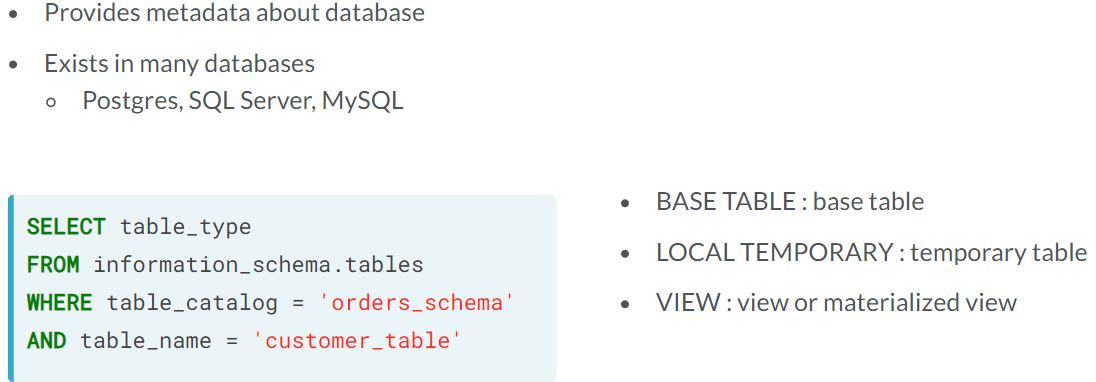

In [2]:
## illustration

### EXERCISEs.
#### Exercise 1.1.  Data loading and storage
The `FROM clause` of a query references data from multiple sources. **Which of the following sources both stores and refreshes data?**

- A) `Base table`
- B) `Temporary table`
- C) `Standard view`
- D) `Materialized view`
- E) A and D
- F) A, B, and D

**Answers & comments.**

- *A. True but not completlly correct!!!*. `Base tables` store data, but *they are not the only option*.
- *B. Incorrect!!* `Temporary tables` temporarily store data but *have no mechanism to refresh data. They are gone with the end of the database session.*
- *C. Wrong!!* `Standard views` only store directions to data.
- *D. True but not completlly correct!!!*. `Materialized views` store data, but *they are not the only option*.
- **E. Correct!!!** The `materialized views` operate similar to base tables. However, their data refresh process runs the view definition. `Base tables`' data refresh process loads data from a source system.
- *F. Wrong!* The options `A & D` is perfect whilt the `temporary tables` temporarily store data but have no mechanism to refresh data. They are gone with the end of the database session, as explained in option `B`!

#### Exercise 1.2.  Finding the table type
Throughout this course, you have been working with data about `Olympic athletes`, `countries' climate`, and `countries' demographics`. 

You may have wondered if these data sources were `actually tables` or `instead views`. 

Knowing this information could help you decide how to **structure your `queries`** and **understand why a `query` may be slow (e.g. it uses a `view`)**.

In this chapter, you will work with `air quality data`. One of the main data sources is **`annual_aqi`**. 

id|state_name|county_name|aqi_year|days_with_aqi|good|moderate|unhealthysensitive|unhealthy|veryunhealthy|hazardous|max_aqi|median_aqi|good_moderate_sum|unhealthy_hazardous_sum
:-|:-|:-|:-|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:
10000|Alabama|Baldwin|2018|205|181|24|0|0|0|0|97|38|205|0
10001|Alabama|Clay|2018|86|79|7|0|0|0|0|64|29|86|0
10002|Alabama|Colbert|2018|205|181|24|0|0|0|0|93|37|205|0
...|...|...|...|...|...|...|...|...|...|...|...|...|...|...
21518|Wyoming|Teton|2008|366|314|52|0|0|0|0|93|42|366|0
21519|Wyoming|Uinta|2008|366|312|53|1|0|0|0|102|42|365|1
21520|Wyoming|Weston|2008|355|353|1|0|1|0|0|160|0|354|1


Determine if it really is a `table`.

#### Instructions 
**Step 1.** Select the `table_type` from the view called `tables` that is in the `information_schema`.

**SOLUTION.**

                    SELECT DISTINCT table_type 
                    FROM information_schema.tables 
                    WHERE table_catalog = 'olympics_aqi'; 
**query result.**

|table_type|
|:-|
|VIEW |
|BASE TABLE |


**Step 2.** Now find all the metadata for a specific table, `annual_aqi`, using the `table_name` column as a filter.

**SOLUTION.**

                        SELECT * FROM information_schema.tables 
                        WHERE table_catalog = 'olympics_aqi' 
                            AND table_name = 'annual_aqi';

- **`query result`.**

table_catalog|table_schema|table_name|table_type|self_referencing_column_name|reference_generation|user_defined_type_catalog|user_defined_type_schema|user_defined_type_name|is_insertable_into|is_typed|commit_action
:-|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
olympics_aqi|public|annual_aqi|`BASE TABLE`|null|null|null|null|null|YES|NO|null

- **Comments.** The `annual_aqi` source is a `base table`. Each view in the `information schema` contains many columns of information. In addition to seeing that `annual_aqi` is a `base table`, you could also see that records can be added to this table by noticing the yes in the `is_insertable_into` column.

## 2. Row-oriented storage and partitions
#### Database stored types.

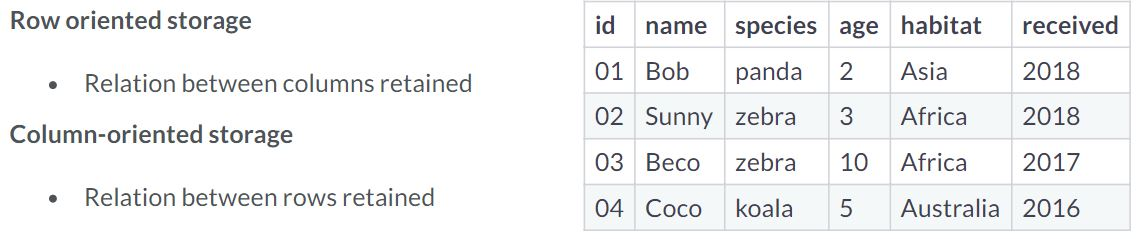

In [3]:
## illustration

#### Row oriented.
- **Row oriented storage.**

$\qquad \qquad \qquad \diamond$ Relation between **columns** retained. For example

| `id` | `name` | `species` | `age` | `habitals` | `received` |
|:-:|:-:|:-:|:-:|:-:|:-:|
| 01 | Bob | panda | 2 | Asia | 2019 |

#### `Column` oriented.

- **Column oriented storage.**

$\qquad \qquad \qquad \diamond$ Relation between **rows** retained. For example


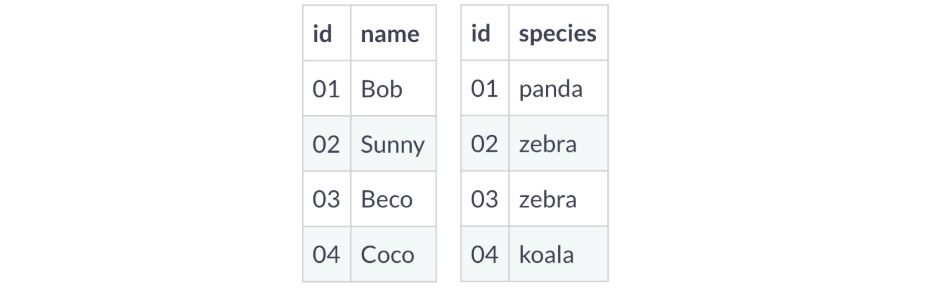

In [4]:
## We will discuss the "column-oriented-storage" later in the final section (Section 4) in this kernel.

### `ROW ORIENTED (cont.)`
- **Row oriented storage (cont)**

$\qquad \qquad \qquad \diamond$ One row is stored in the **same `location`**.

$\qquad \qquad \qquad \diamond$ **Fast** to *`append`* or *`delete`* whole records.

$\qquad \qquad \qquad \diamond$ **Quick** to return all columns, but **slow** to returns all rows.

- **REDUCING the ROWs** 
There are many `SQL` commands to restrict the **number of `rows`**, such as: 

$\qquad \qquad \qquad \diamond$ `WHERE` : filter under some specificed conditions.

$\qquad \qquad \qquad \diamond$ `INNER JOIN` : joins data based on the `common column`

$\qquad \qquad \qquad \diamond$ `DISTINCT` : extract the `unique values` in the `chosen column`

$\qquad \qquad \qquad \diamond$ `LIMIT`: print out the `first many rows`.

- **Row-oriented database methods**

$\qquad \quad \blacksquare$ **Using `Partition`.** Method of splitting `one (parent)` `table` into many, `smaller (children)` tables.

$\qquad \quad \blacksquare$ **Using `Indexes`.** Method of creating `sorted column keys` to improve search.

$\qquad \quad \blacksquare$ **Using both `indexes` & `partition`.**

$\qquad \qquad \qquad \diamond$ Require `set up` and `maintance`.

$\qquad \qquad \qquad \diamond$ `Existence known` from `database administrator` or `documentation`.

#### `PARTITION` structure from `ROW oriented`

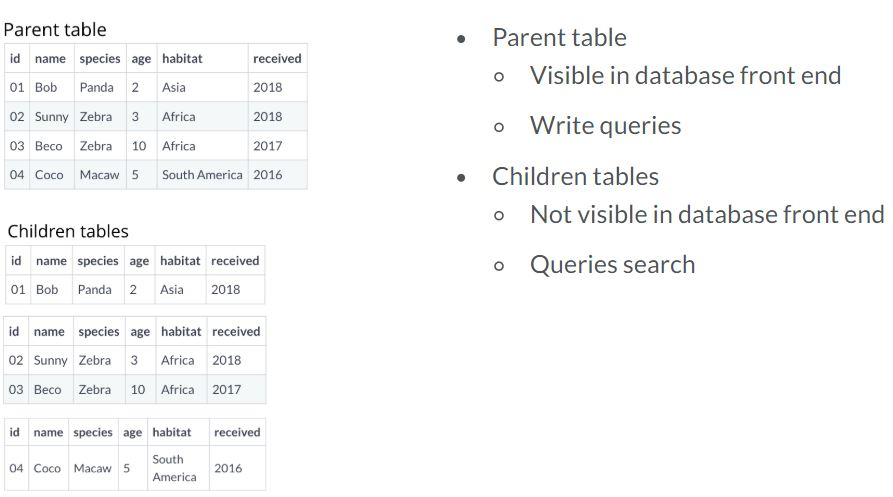

In [5]:
## illustration

Using the `reduction` with command `WHERE habitat = 'Africa'`; the output returns the second one in the `children tables`

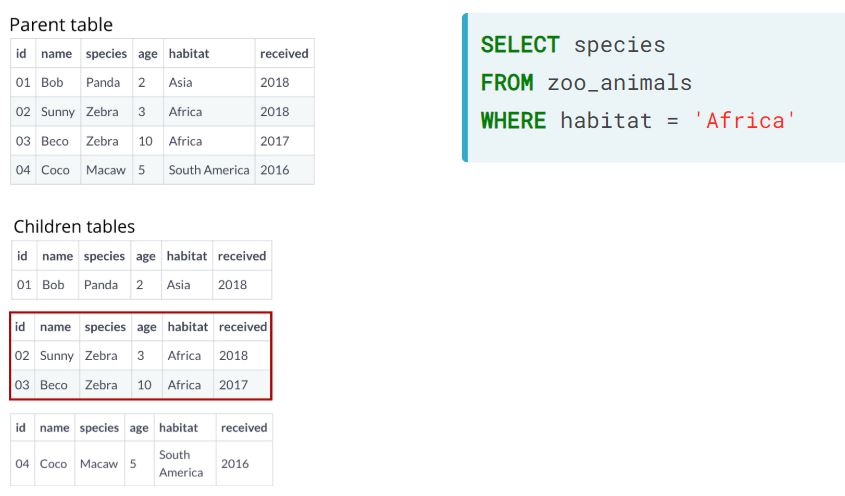

In [6]:
## illustration 

#### `PARTITION` overview.
$\qquad \quad \blacksquare$ **`WHAT`.** Splitting `one table` into `many smaller tables`.

$\qquad \quad \blacksquare$ **`WHY`.** `Storage flexibility` and `faster queries`.

$\qquad \quad \blacksquare$ **`HOW`.** Based on the `common filter columns`; such as `date`, `location`, etc.

#### Partition query assessment.

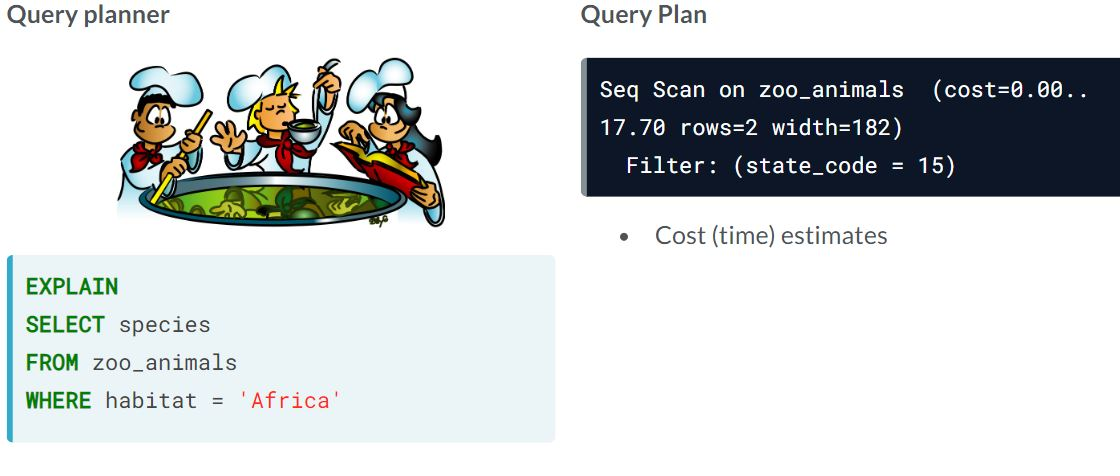

In [7]:
## illustration

### EXERCISEs
#### Exercise 2.1. Row-oriented storage properties
$\quad \quad$ `Databases store data` in **two main formats**, `row-oriented storage`, and `column-oriented storage`. 

$\quad \quad$ `Postgres` inherently uses `row-oriented storage`.

**Question.** Choose the statements that **correctly explain the properties of `row-oriented storage` in a `database`**.

- `A)` The `relation` between `columns` is `retained`.
- `B)` The `relation` between `rows` is `retained`.
- `C)` A `single row` of data (all `columns`) is stored in `multiple locations`.
- `D)` `Queries` quickly return all `rows`.
- `E)` `B` and `D`

**Answers & comments.**
- **A Correct!!!** `Row-oriented storage` keeps the association between `columns`.
- *B. Wrong!!* This reason is true for `column-oriented` but not **`row-oriented storage`**.
- *C. Wrong!!* One `row` is treated as one `record`. Each record is stored in only one `location`.
- *D. Incorrect!!* Each `row` is a record and limiting the number of records `speeds queries`.
- *E. Incorrect!!* The `row relationships` and returning all rows quickly are properties of `column-oriented storage`, not **`row-oriented storage`**.

#### Exercise 2.2. Previewing a `row-oriented` table
$\quad \quad$ When working with new `tables`, it is common to `SELECT *` to preview the data. 

$\quad \quad$ However, selecting all the `rows` from a **`large table`** using `row-oriented storage` is ***resource intensive and slow***. 

$\quad \quad$ A `quick optimization trick` is to **`limit the number of rows returned`**.

You will be working with air quality data from the United States. This data lives in a `Postgres database` using `row-oriented storage`. Familiarize yourself with `daily_aqi` by previewing the data. 

First, select all records. Then limit the results to improve speed.

Use the `EXPLAIN` `command` to **quantify the effect** of `limiting the rows`.

#### Instructions 
**Step 1.** Check the `query` cost estimate of a `SELECT * statement`.

**SOLUTION.**

                        EXPLAIN
                        SELECT *
                        FROM daily_aqi;
- **`query result.`**

|`QUERY PLAN`|
|:-:|
|`Seq Scan on daily_aqi  (cost=0.00..695.33 rows=31433 width=62)`|

**Step 2.** Check the `query` cost estimate `after limiting to 10 records`.

**SOLUTION.**

                        EXPLAIN
                        SELECT *
                        FROM daily_aqi
                        LIMIT 10;
- **`query result.`**

|`QUERY PLAN`|
|:-|
|`Limit  (cost=0.00..0.22 rows=10 width=62)`|
|`->  Seq Scan on daily_aqi  (cost=0.00..695.33 rows=31433 width=62)`|

- **Comments.** `LIMIT` is a handy clause to reduce the number of records and `EXPLAIN` shows how it reduces the query cost. 

#### Exercise 2.3. Partitioning on location
$\quad \quad$ The `Air Quality Index (AQI)` is calculated on **four air pollutants**: (`ozone`, `particle pollution`, `carbon monoxide (CO)`, and `sulfur dioxide (S02)`) then categorized into `six levels`.

$\quad \quad$ Air quality in the US is monitored on a `state level`, with states reporting data to the `Environmental Protection Agency (EPA)`. 

Because of these different sources, the `air quality` table is partitioned by state. While it looks like one table, each state has its own `child table`.

Find the cost estimate **`impact of the partition`**. Then find the best days and places to visit in Hawaii based on the `AQI`.

#### Instruction
**Step 1.** Filter to Hawaii (`state_code = 15`) and check the `query cost` estimate on an **`unpartitioned version`** of the `table`.

**SOLUTION.**

                        EXPLAIN
                        SELECT * 
                        FROM daily_aqi
                        WHERE state_code = 15; -- Hawaii state code

- **`query result.`**

|`QUERY PLAN`|
|:-|
|`Seq Scan on daily_aqi  (cost=0.00..773.91 rows=964 width=62)`|
|$\quad$ `Filter: (state_code = 15)`|

**Step 2. Check the `query cost` estimate on a **`partitioned version`** of the `table`.

**SOLUTION.**

                        EXPLAIN
                        SELECT * 
                        FROM daily_aqi_partitioned
                        WHERE state_code = 15; -- Hawaii state code
- **`query result.`**

|`QUERY PLAN`|
|:-|
|`Seq Scan on daily_aqi_partitioned  (cost=0.00..17.70 rows=2 width=182)`|
|$\quad$`Filter: (state_code = 15)`|

**Step 3.** Now use the `partition` on `state_code` to find the days with the best air quality in `Hawaii (15)`.

**SOLUTION.**

                        SELECT county_name, aqi, category, aqi_date
                        FROM daily_aqi_partitioned
                        WHERE state_code = 15 
                        ORDER BY aqi;
- **`query result.`**

county_name|aqi|category|aqi_date
:-|:-:|:-|:-:
Honolulu|1|Good|2018-09-01
Kauai|1|Good|2018-02-01
Kauai|2|Good|2018-05-28
Kauai|3|Good|2018-01-13
Kauai|3|Good|2018-01-14
...|...|...|...
Hawaii|204|Very Unhealthy|2018-06-02
Hawaii|207|Very Unhealthy|2018-07-23
Hawaii|215|Very Unhealthy|2018-06-15
Hawaii|244|Very Unhealthy|2018-07-02
Hawaii|249|Very Unhealthy|2018-06-20

- **Comment.** Using a `partitioned column` in the `WHERE clause` limited the search field to the smaller table of `Hawaii`, reducing the query cost by a factor of `~32`. `Feel free to take a break and start looking up Honolulu flights` in `September`!

## 3. Using and creating indexes
### Index overview.
- **`What`.** 

$\qquad \quad \diamond$ `Method` of `creating sorted column keys` to improve search.

$\qquad \quad \diamond$ Similar to `book index`.

$\qquad \quad \diamond$ Reference to `data location`.

- **`Why`.** Faster `queries`.
- **`Where`.** on

$\qquad \quad \diamond$ Common `filter columns`

$\qquad \quad \diamond$ `PRIMARY KEY`

#### Index example.

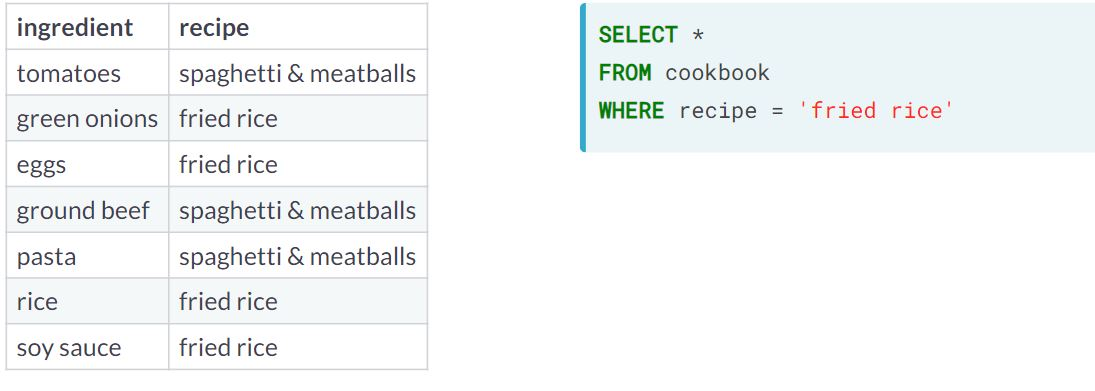

In [8]:
## illustration 

#### Index as a `key` & `pointer`.

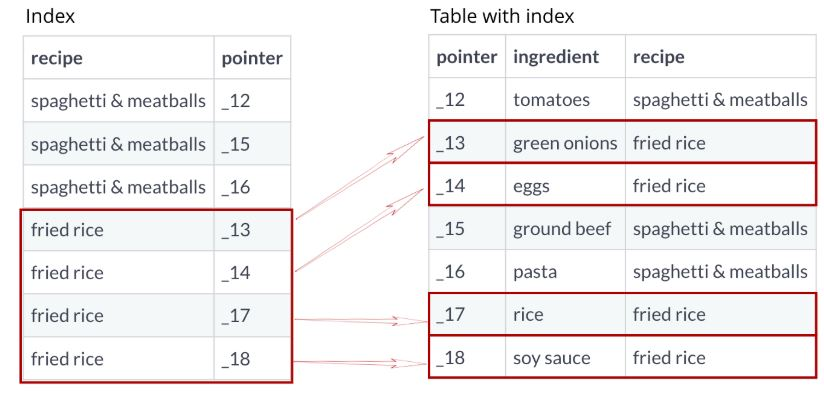

In [9]:
## illustration

### Finding `existing indexes`

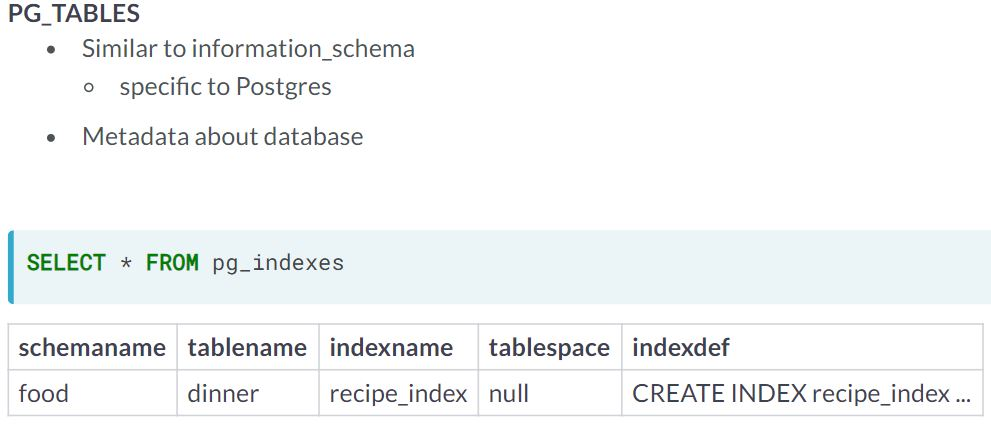

In [10]:
## illustration

### Creating an `index`
**`Syntax`.**

                    CREATE INDEX index_names
                    ON table_name(column_to_index);
or `concurrently index`                   

                    CREATE INDEX CONCURRENTLY index_names
                    ON table_name(column_to_index, column_to_index);

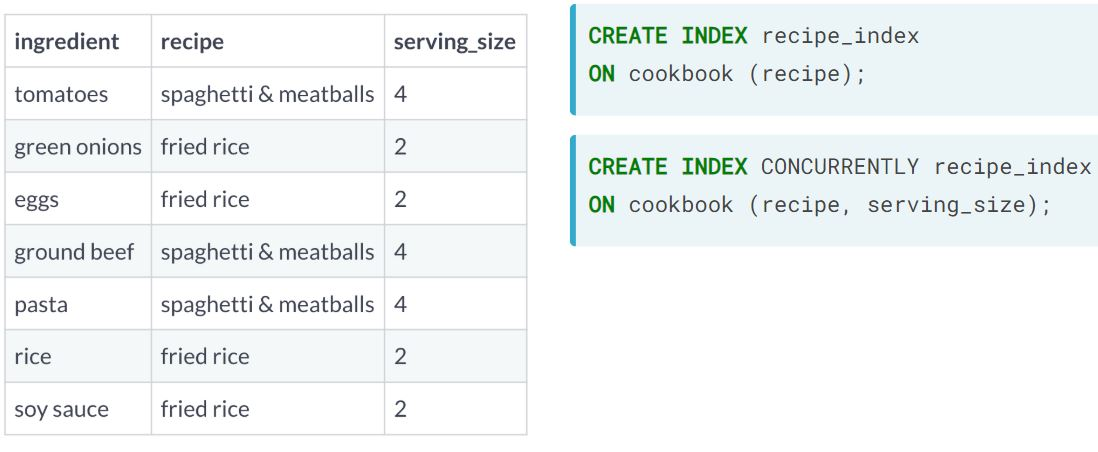

In [11]:
## illustration 

### To `use` and `not to use`

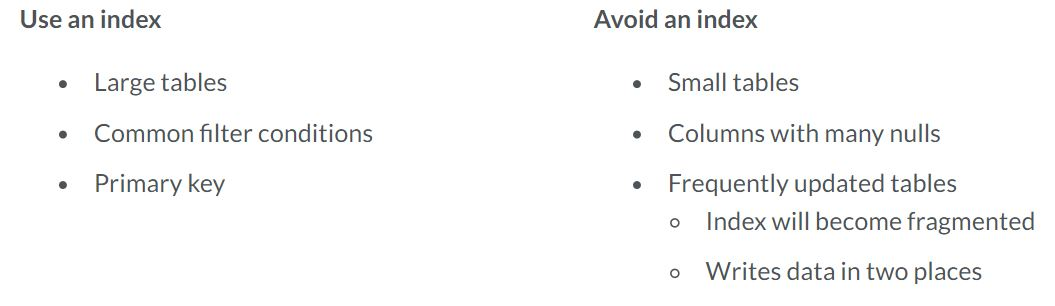

In [12]:
## illustration 

### `Frequently updated tables`.

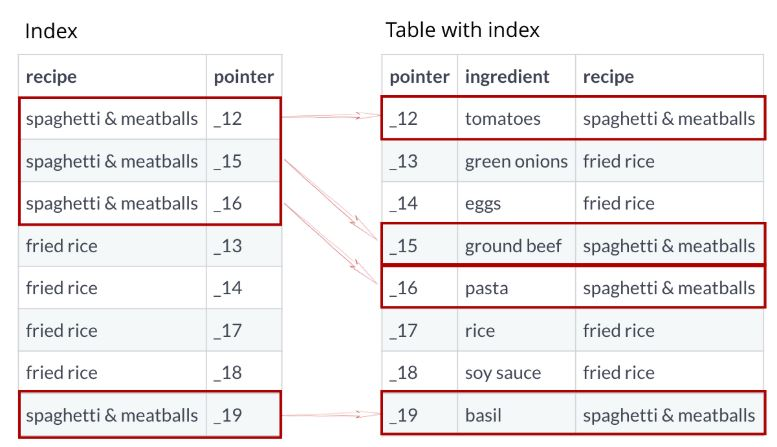

In [13]:
## illustration 

### `Index query assessment`

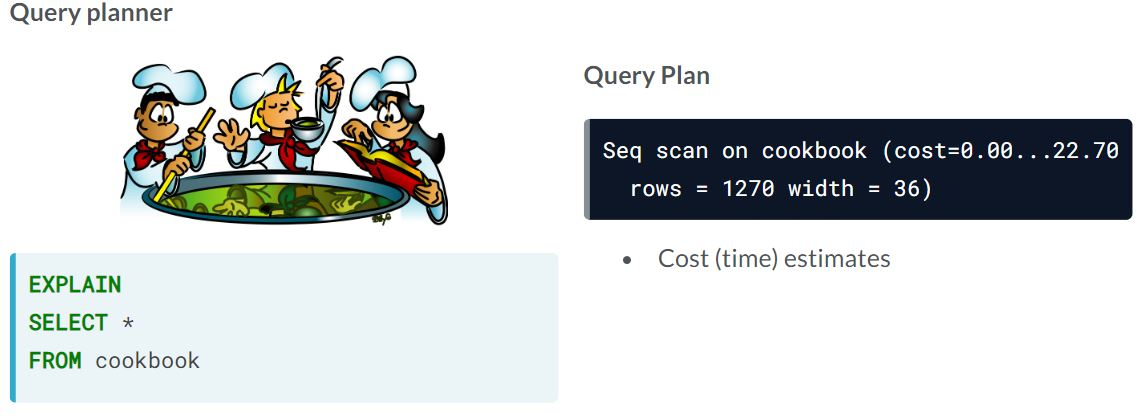

In [14]:
## illustration 

### EXERCISEs.
#### Exercise 3.1.  Finding the `database indexes`
$\qquad \quad$ One aspect of writing **`well-performing queries`** is using the `database optimization` properties. 

$\qquad \quad$ When working in `row-oriented databases`, you want to `limit` the number of records returned. 

$\qquad \quad$ If `partitions` and `indexes` exist, you should use them in your `queries` as `filters`. 

Ideally, you could reference a `database diagram` or ask your friendly `database administrator (DBA)` which tables and columns have `indexes`.

However, sometimes `documentation` is missing, and `DBAs` are busy. Luckily, the `pg_tables` `schema` has views that show all the `existing indexes`.

#### Instructions
- Choose `metadata` from the `pg_indexes` `view`.
- Select `tablename` and `indexname` to see the indexes in each `table`.

**SOLUTION.**

                    SELECT tablename, indexname
                    FROM pg_indexes;
- **`query result`.**

tablename|indexname
:-|:-
annual_aqi|annual_aqi_pkey
annual_aqi_2018|annual_aqi_2018_pkey
athletes_recent|athletes_recent_pkey
athletes_summ|athletes_summ_pkey
athletes_wint|athletes_wint_pkey
climate|climate_pkey
daily_aqi|daily_aqi_pkey
daily_aqi_hi|daily_aqi_hi_pkey
demographics|demographics_pkey
oregions|oregions_pkey
...|...
pg_ts_dict|pg_ts_dict_oid_index
pg_ts_dict|pg_ts_dict_dictname_index
pg_ts_parser|pg_ts_parser_prsname_index
pg_ts_parser|pg_ts_parser_oid_index
pg_ts_template|pg_ts_template_tmplname_index
pg_ts_template|pg_ts_template_oid_index
pg_type|pg_type_typname_nsp_index
pg_type|pg_type_oid_index
pg_user_mapping|pg_user_mapping_user_server_index
pg_user_mapping|pg_user_mapping_oid_index

- **Comments.** Notice that each `table` has an `index` with the `pkey suffix`, indicating a `primary key index`.

#### Exercise 3.2. Creating and using an index
$\qquad \quad$ You are working with the US `Air Quality Index (AQI)` data. 

$\qquad \quad$ `AQI` data captures `four pollutants`: `ozone, particle pollution, carbon monoxide`, and `sulfur dioxide`. 

You want to know if one of `these pollutants` is the main source of poor air quality.

The `daily_aqi` table contains `daily AQI measurements`. The `defining_parameter` field describes which of the four pollutants was the **worst for that day**.

You will be writing a lot of queries using the `pollutant type` as a filter. Before you dig into the data, you want to check if `defining_parameter` has an index on it. If not, you want to add one.

#### Instructions
**Step 1.**
- Use the `pg_indexes` `view` to find `existing indexes`.
- Filter to the `daily_aqi` table.

**SOLUTION.**

                    SELECT indexname
                    FROM pg_indexes
                    WHERE tablename = 'daily_aqi'; -- Filter condition

- **`query result`.**

|`indexname`|
|:-|
|`daily_aqi_pkey`|


**Step 2.**
- Use the `defining_parameter` column to create an `index`.
- Check that the `index` was created successfully by finding the `indexname` in the `pg_indexes` `view`.

**SOLUTION.**

                CREATE INDEX defining_parameter_index 
                             ON daily_aqi (defining_parameter); -- Define the index creation

                SELECT indexname -- Check for the index
                FROM pg_indexes
                WHERE tablename = 'daily_aqi';

- **`query result.`**

|`indexname`|
|:-|
|`daily_aqi_pkey`|
|`defining_parameter_index`|

- **Comments.** The `daily_aqi` table originally only had a `primary key index`: `daily_aqi_pkey`. You successfully added `another index`, which you can use to speed your `queries` while looking at `pollutant types`.

#### Exercise 3.3. Compare runtimes
$\qquad \quad$ `Hawaii` is home to many volcanoes. One volcano, `Kīlauea` has been erupting nearly continuously since `1983`. 

$\qquad \quad$ The `spewing volcanic smog (vog)` is high in `sulfur dioxide (SO2)` and results in poor air quality. 

In fact, based on the count of good or moderate air quality days over 10 years (2008 to 2018), `Hawaii` has the `worst air quality of any state`.

In this exercise, you will look at the main `air pollutant` on `poor air quality days`, `focusing on SO2`. You will compare the cost estimate between a query with an index on the pollutant column and a **`query` without an `index`**.

#### Instructions
**Step 1.** Find the `records` with `poor air quality` by using the `category` column to filter out `Good air quality days` in `Hawaii`.

**SOLUTION.**

                        SELECT category, 
                               COUNT(*) as record_cnt, 
                               SUM(no_sites) as aqi_monitoring_site_cnt
                        FROM daily_aqi
                        WHERE category <> 'Good'
                              AND state_code = 15 -- Filter to Hawaii
                        GROUP BY category;
- **`query result`**

category|record_cnt|aqi_monitoring_site_cnt
:-|:-:|:-:
Unhealthy|99|670
Very Unhealthy|5|34
Moderate|69|427
Unhealthy for Sensitive Groups|64|436

**Step 2.** Add a `SO2` (sulfur dioxide) `defining_parameter` filter and note the overall query cost estimate.

**SOLUTION.**

                        EXPLAIN
                        SELECT category, 
                               COUNT(*) as record_cnt, 
                               SUM(no_sites) as aqi_monitoring_site_cnt
                        FROM daily_aqi
                        WHERE defining_parameter = 'SO2'
                        AND category <> 'Good'
                        AND state_code = 15 -- Filter to Hawaii
                        GROUP BY  category;
- **`query result`**

|`QUERY PLAN`|
|:-|
|`GroupAggregate  (cost=931.12..931.19 rows=3 width=22)`|
|$\,$ `Group Key: category`|
|$\; \;$ ` ->  Sort  (cost=931.12..931.13 rows=4 width=8)`|
|$\qquad $   `     Sort Key: category`|
|$\;\quad$  `      ->  Seq Scan on daily_aqi  (cost=0.00..931.08 rows=4 width=8)`|
|$\quad \qquad$`              Filter: ((category <> 'Good'::text) AND (defining_parameter = 'SO2'::text) AND (state_code = 15))`|

**Step 3.** Create an index on the `defining_parameter`. Is the `query` cost estimate smaller than the prior query's estimate?

**SOLUTION.**

                    CREATE INDEX defining_parameter_index 
                            ON daily_aqi (defining_parameter); 

                    EXPLAIN
                    SELECT category,
                           COUNT(*) as record_cnt,
                           SUM(no_sites) as aqi_monitoring_site_cnt
                    FROM daily_aqi
                    WHERE defining_parameter = 'SO2'
                    AND category <> 'Good'
                    AND state_code = 15 -- Hawaii
                    GROUP BY  category;

- **`query result`**

|`QUERY PLAN`|
|:-|
|`GroupAggregate  (cost=301.78..301.80 rows=1 width=48)`|
|$\,$ `Group Key: category`| 
|$\, \,$  ` ->  Sort  (cost=301.78..301.78 rows=1 width=34)` |
|$\qquad $  `  Sort Key: category` |
|      `  ->  Bitmap Heap Scan on daily_aqi  (cost=5.47..301.77 rows=1 width=34)` |
|$\qquad$         `  Recheck Cond: (defining_parameter = 'SO2'::text)` |
| $\qquad$     `  Filter: ((category <> 'Good'::text) AND (state_code = 15))` |
|$\qquad$      `  ->  Bitmap Index Scan on defining_parameter_index  (cost=0.00..5.46 rows=157 width=0)` |
|$\qquad \qquad$    `         Index Cond: (defining_parameter = 'SO2'::text)` |


- **Comments.** An `index` did `decrease` the (unitless) `query cost` estimate from `~600` to `~400`. `Sulfur dioxide gas` from `volcanoes` seems to be the `main pollutant` for `Hawaiian cities`.

## 4. Using `column-oriented storage`
#### `Column-oriented`

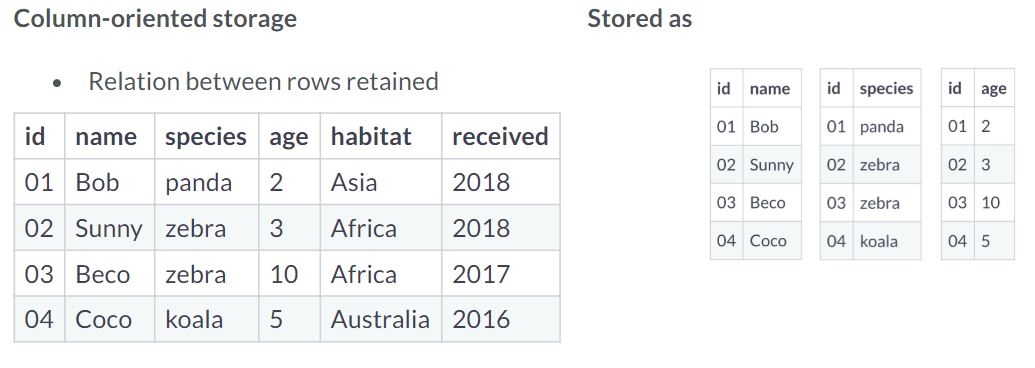

In [15]:
## illustration 

#### `Analytic focus - a good fit`.

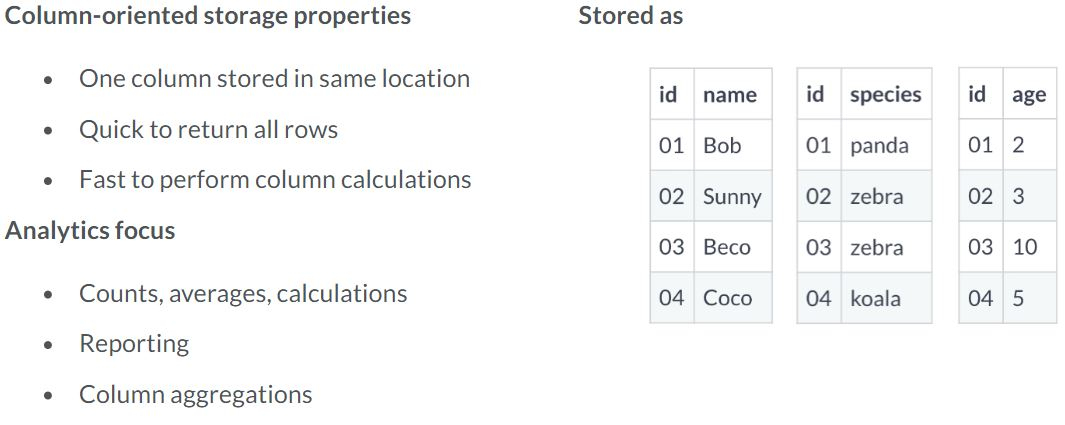

In [16]:
## illustration 

#### `Transaction focus- a poor fit`

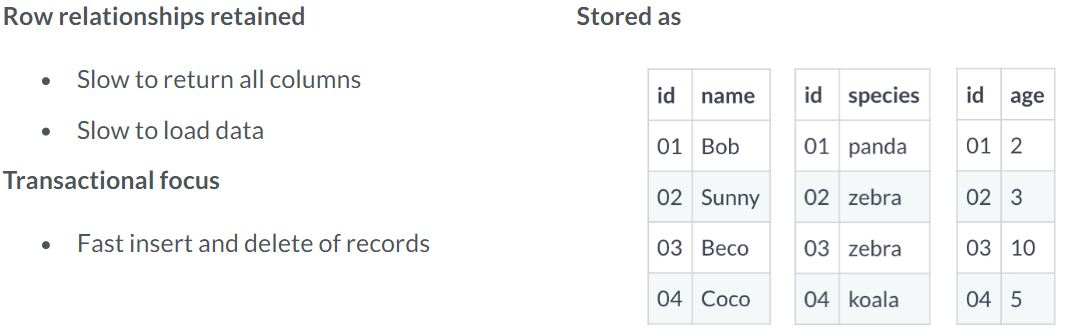

In [17]:
## illustration 

#### Database example

| `Postgres` | `MySQL` | `Oracle` |
|:-:|:-|:-:|
| `Citus data`, `Greenplum`, `Amazon Redshift`| `MariaDB` | `Oracle In-Memory Cloud Store`, `Clickhouse`, `Apache Druid`, `CrateDB` |

#### Information schema.

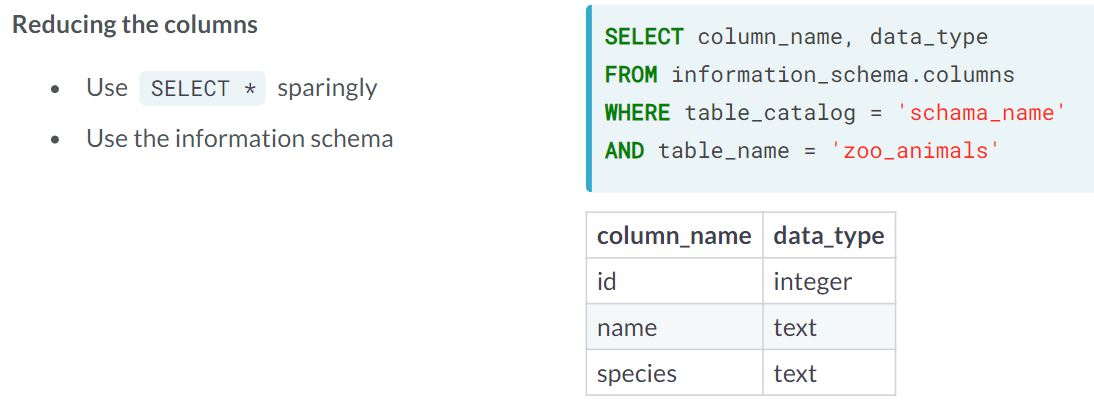

In [18]:
## illustration 

### Writing your `queries`

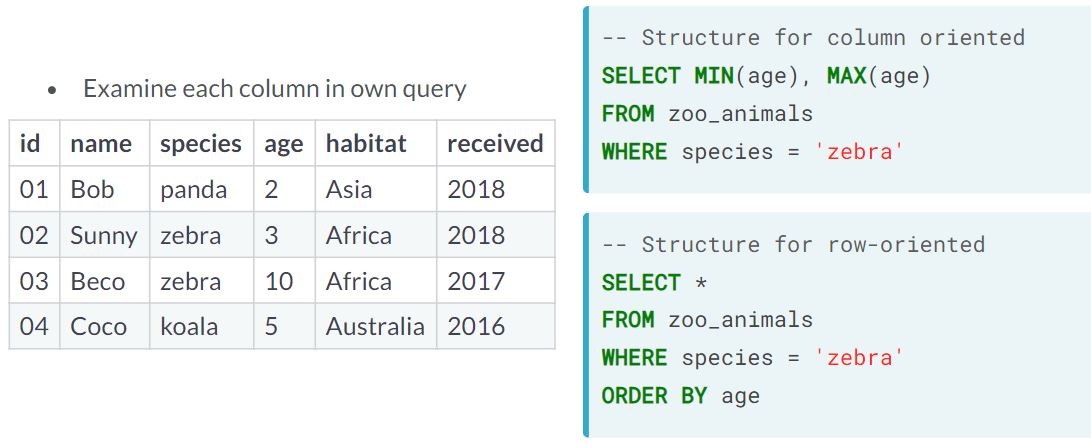

In [19]:
## illustration 

### EXERCISEs.
#### Exercise 4.1. `Column-oriented storage` properties
$\qquad$ You are at a small company that is just starting to build its data infrastructure. You are discussing with coworkers the best type of database structure for the `company data warehouse`. 

$\qquad$ The [data warehouse](https://www.datacamp.com/community/blog/data-lakes-vs-data-warehouses) will bring together data from multiple source systems such as `human resources` data, `financial` data, and `customer` data.

You think you should use a database that uses `column-oriented storage`.

**Question.** Which of these reasons **does NOT support your argument**?

- A. The `data warehouse` will primarily be used for reporting. 
- B. Much of the reporting will be finding averages of `single metrics`, such as `average employee tenure`.
- C. As a new company, most reporting will look at all the `records`.
- D. The `data` needs to be real time so `records` will continually be appended to tables in the `warehouse`.

**Answers & comments.**
- *A. Wrong!!* `Column-oriented storage` is a **good solution** for `read-only queries` which serve the basis for most reports.
- *B. Incorrect!!* `Column calculations`, such as finding `averages`, **is one of the strengths** of `column-oriented storage`.
- *C. Wrong!!* `Returning all the rows` will **not impact the performance** in `column-oriented storage`.
- **D. Correct!!!** `Column-oriented storage` databases are **slow to insert records**. `Constantly appending` data will *significantly slow performance*.

#### Exercise 4.2. Using the information schema
$\qquad$ The most `basic optimization method` with `column-oriented storage` databases is to reduce the `number of columns` each `query` returns.

$\qquad$ When working with new tables, it is common to select the first 5 or 10 rows. 

$\qquad$ However, a basic select on a `wide table` may be `resource intensive`. 

$\qquad$ The `information schema` provides some column metadata and is a good starting place to learn about your data.

While it does not show as available, views in the `information_schema` are always available to `query`. Feel free to explore the columns view in the `console` to explore what information is available before completing the exercise.

#### Instructions.
- Use the columns `view` from the `information_schema`.
- Select the `column_name`, `data_type`, and `is_nullable` columns.
- Use `table_name` to limit results to the `daily_aqi` table.

**SOLUTION.**

                -- Examine metadata about daily_aqi
                SELECT column_name , data_type , is_nullable
                FROM information_schema.columns
                WHERE table_catalog = 'olympics_aqi'
                AND table_name = 'daily_aqi' -- Limit to a specific table
                ;

- **`query result`.**

column_name|data_type|is_nullable
:-|:-|:-
id|integer|NO
state_name|text|YES
county_name|text|YES
state_code|integer|YES
county_code|integer|YES
aqi_date|date|YES
aqi|integer|YES
category|text|YES
defining_parameter|text|YES
defining_site|text|YES
no_sites|smallint|YES

- **Comments.**

$\qquad \qquad \diamond$ The `information schema` is a useful `schema` to explore. Without doing a `SELECT *` from `daily_aqi`, you can quickly and easily see that this table has dates (`aqi_date`) corresponding to `daily AQI measurements` from multiple sites (`no_sites`) at the `county level`.

$\qquad \qquad \diamond$ Noting that if you using `table_name = "daily_aqi"` in the `last command`, then you will make a mistake; then you will get an `error message` as follow:

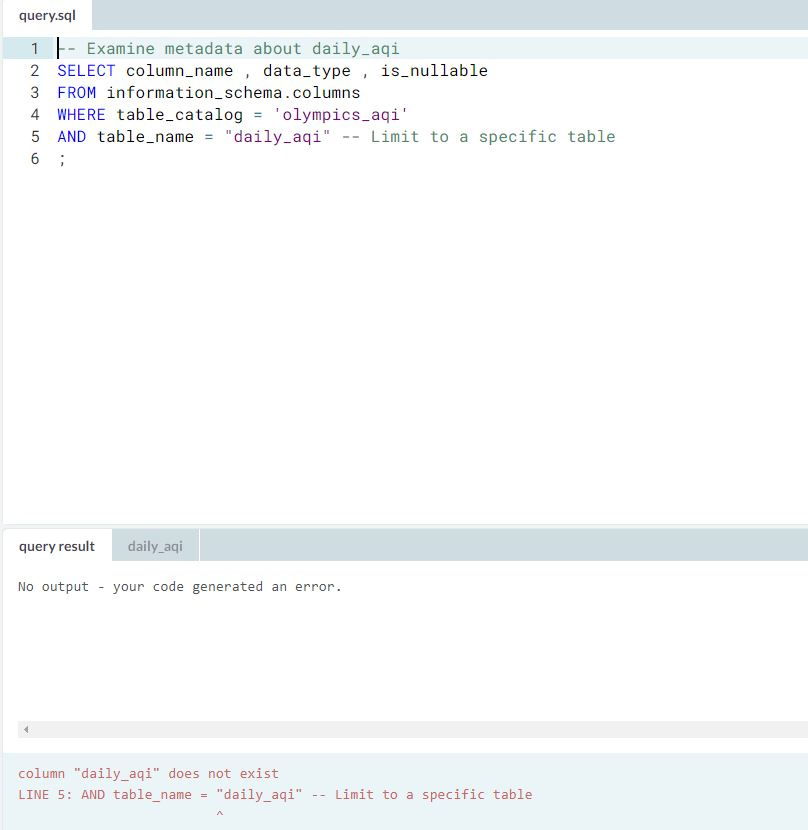

In [20]:
## illustration the error message